In [1]:
import sys
import numpy
import pandas
import matplotlib
import seaborn 
import scipy
import sklearn

print('Python Version: {}'.format(sys.version))
print('numpy Version: {}'.format(numpy.__version__))
print('pandas Version: {}'.format(pandas.__version__))
print('matplotlib Version: {}'.format(matplotlib.__version__))
print('seaborn Version: {}'.format(seaborn.__version__))
print('scipy Version: {}'.format(scipy.__version__))
print('sklearn Version: {}'.format(sklearn.__version__))



Python Version: 3.6.4 |Anaconda custom (64-bit)| (default, Dec 21 2017, 21:42:08) 
[GCC 7.2.0]
numpy Version: 1.13.3
pandas Version: 0.21.1
matplotlib Version: 2.1.1
seaborn Version: 0.8.1
scipy Version: 1.0.0
sklearn Version: 0.19.1


In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn

In [3]:
ccdata = pd.read_csv('creditcard.csv')

In [4]:
print(ccdata.shape)

(284807, 31)


In [5]:
print(ccdata.describe())

                Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  3.919560e-15  5.688174e-16 -8.769071e-15  2.782312e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 V5            V6            V7            V8            V9  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean  -1.552563e-15  2.010663e-15 -1.694249e-15 -1.927028e-16 -3.137024e-15   
std    1.380247e+00  1.332271e+00  1.23709

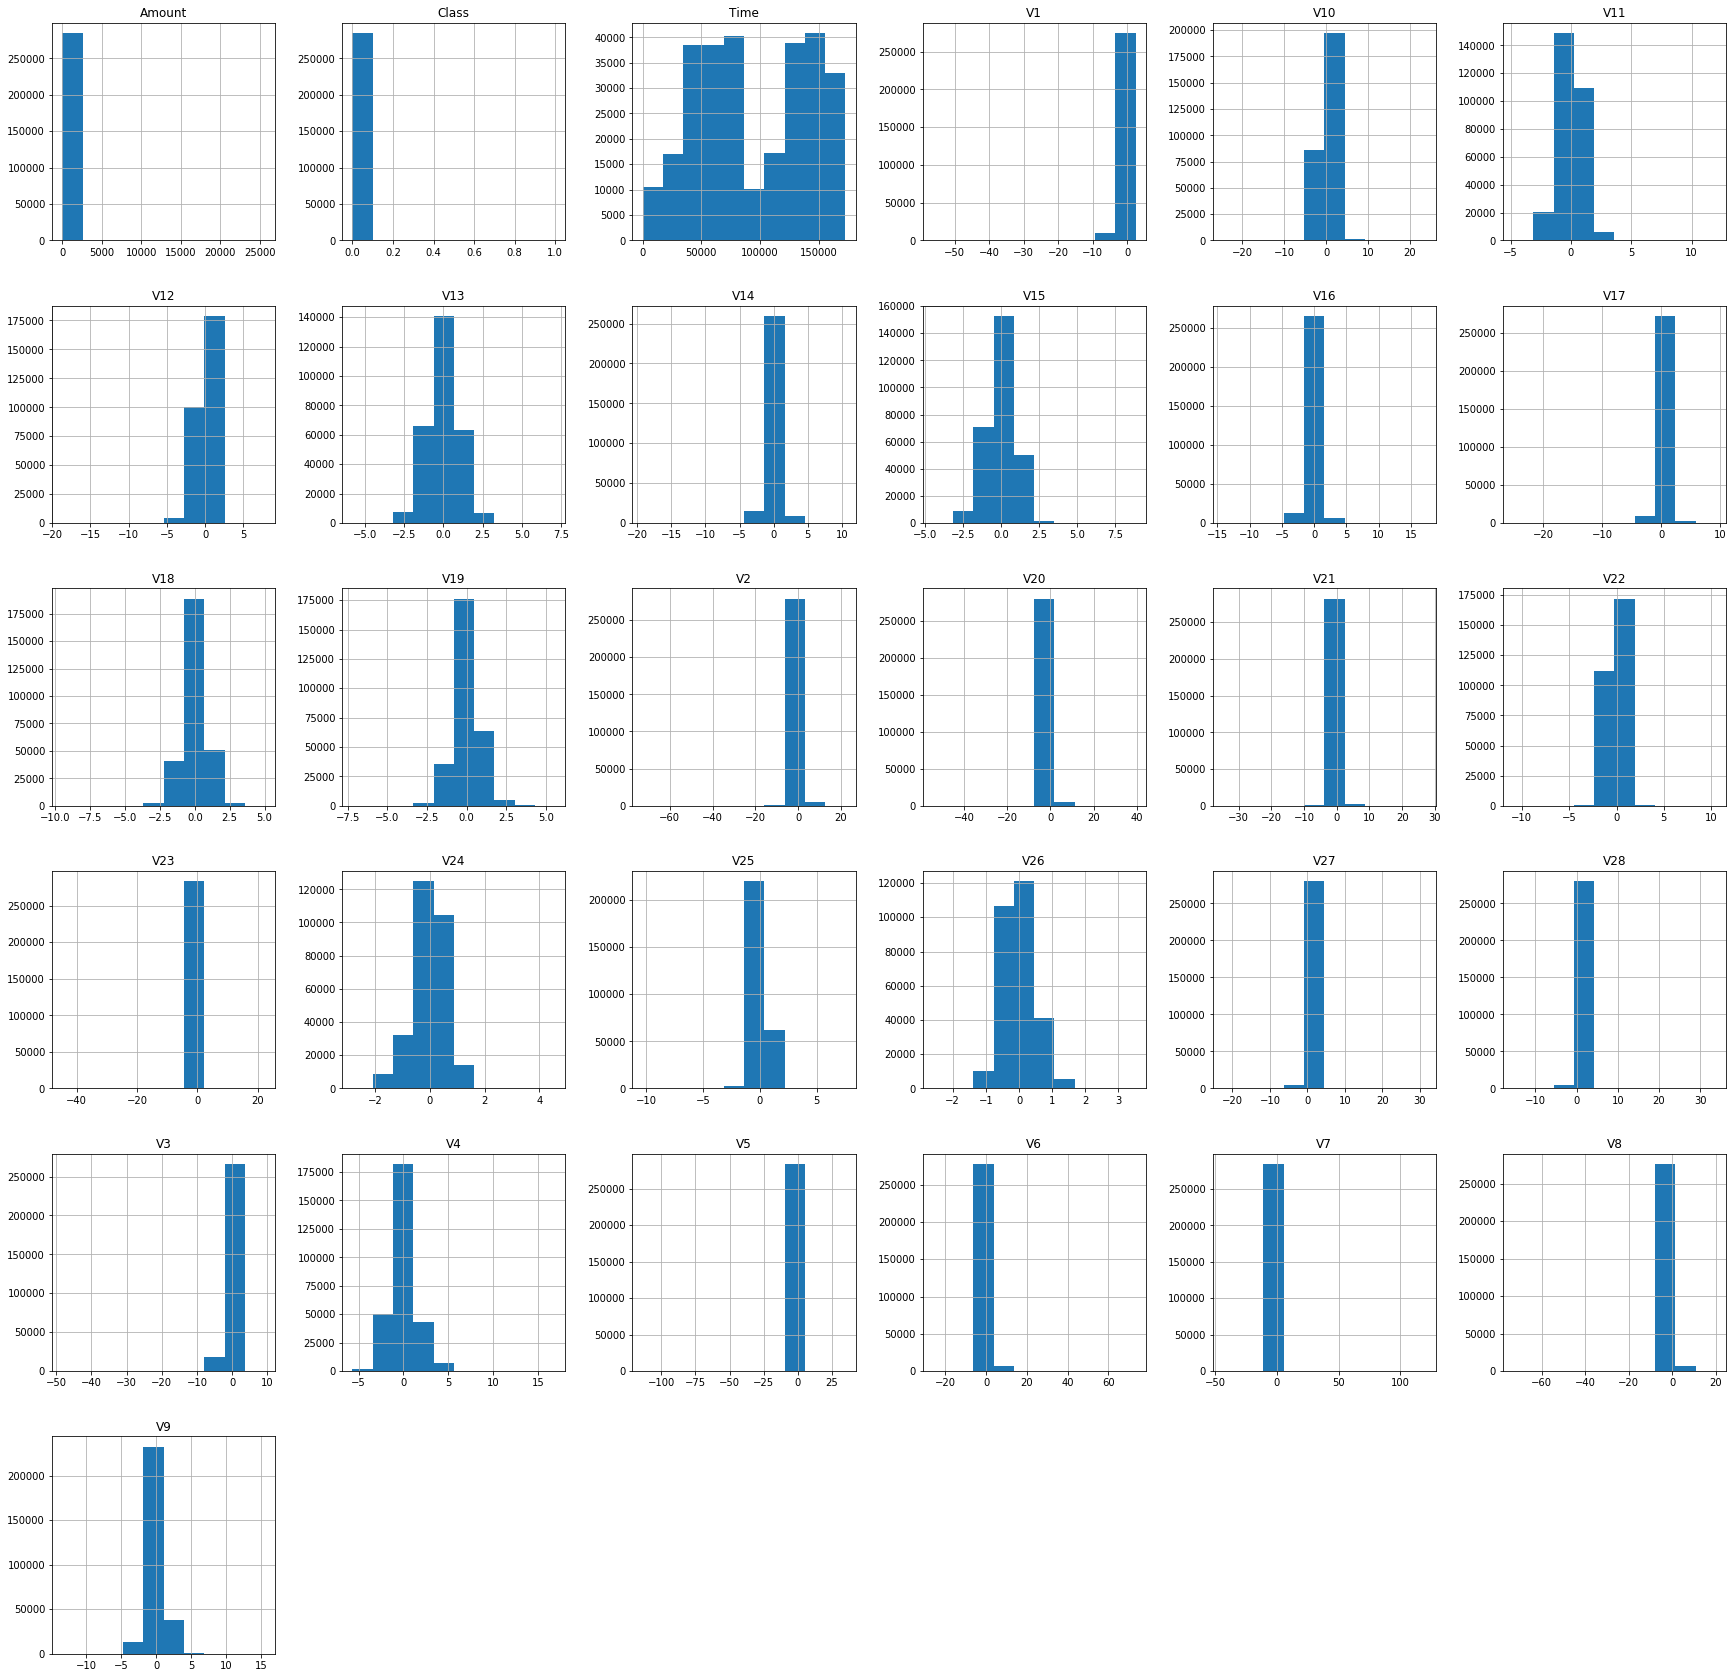

In [6]:
ccdata.hist(figsize = (30,30))
plt.show()

In [7]:
# Number of fraudulent cases : can this be a good thing to train? 
Fraud = ccdata[ccdata['Class']==1]
Legit = ccdata[ccdata['Class']==0]

fraud_frac = float(len(Fraud)) / float((len(Legit)+len(Fraud)))
print(fraud_frac)

print('Number of Fraud cases: {}'.format(len(Fraud)))
print('Number of Legit cases: {}'.format(len(Legit)))

0.001727485630620034
Number of Fraud cases: 492
Number of Legit cases: 284315


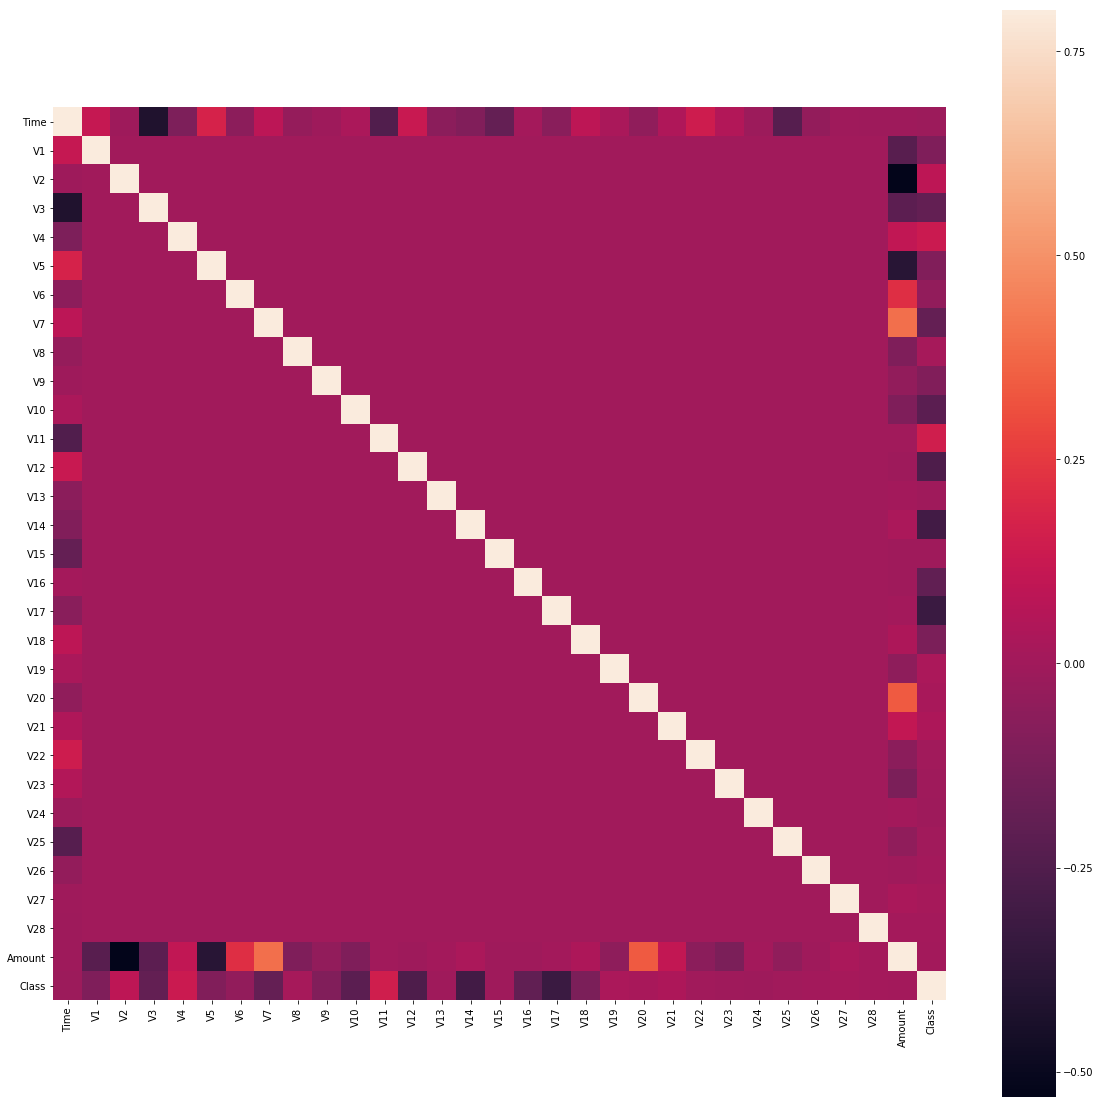

In [8]:
# Check for correlation : checking for data relationships in case we need to remove data 
correlation_mat = ccdata.corr()  
corr_fig = plt.figure(figsize=(20,20))

sbn.heatmap(correlation_mat, vmax = .8, square = True)
plt.show()

# We see that there aren't a lot of 1:1 correlations (no need to pull out data)
# No obvious correlations between class, time, amount

In [9]:
# Format data as a list
columns_list = ccdata.columns.tolist()

# Remove 'Class" (as it contains Fraudulent labels)
columns_list = [c for c in columns_list if c not in ["Class"]]


# Store the variable we will predict (Class)
target = "Class"
X = ccdata[columns_list]
Y = ccdata[target]
X = X.fillna(X.mean())
#Y = Y.fillna(Y.mean())

# Check that no Class label in X and Y contains answers (class labels)
print(X.shape)
print(Y.shape)

(284807, 30)
(284807,)


In [10]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.neighbors import LocalOutlierFactor

rstate = 1 

classifiers = {
    "Isolation Forest": IsolationForest(max_samples=len(X),
                                        contamination = fraud_frac,
                                        random_state = rstate),
    "Local Outlier Factor": LocalOutlierFactor(
    n_neighbors = 15,
    contamination = fraud_frac)
}

In [11]:
# Model Fitting 
num_outliers = len(Fraud)

for c, (clf_name, clf) in enumerate(classifiers.items()):
    
    # fitting and tagging outliers in data 
    if clf_name == "Local Outlier Factor": 
        y_prediction = clf.fit_predict(X)
        scores_predictions = clf.negative_outlier_factor_
    else: 
        clf.fit(X)
        scores_predictions = clf.decision_function(X)
        y_prediction = clf.predict(X)
    
    # reshape data 
    y_prediction[y_prediction == 1] = 0.0 
    y_prediction[y_prediction == -1] = 1.0 # classify outliers as fraud
    
    num_errors = (y_prediction != Y).sum()
    
    print('{} {} errors'.format(clf_name, num_errors))
    print(accuracy_score(Y,y_prediction))
    print(classification_report(Y, y_prediction))

Isolation Forest 644 errors
0.997738819622
             precision    recall  f1-score   support

          0       1.00      1.00      1.00    284315
          1       0.35      0.35      0.35       492

avg / total       1.00      1.00      1.00    284807

Local Outlier Factor 924 errors
0.996755697718
             precision    recall  f1-score   support

          0       1.00      1.00      1.00    284315
          1       0.06      0.06      0.06       492

avg / total       1.00      1.00      1.00    284807

